<a href="https://colab.research.google.com/github/JaiderSantos/metodos1_JaiderSantos_NicolasGomez/blob/main/Parcial3/HiggsB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [98]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
!pip install emcee
!pip install corner
import emcee
import corner

In [141]:
# Cargar los datos
data = pd.read_csv("HiggsFitting.csv")  # Ajusta el nombre del archivo
Masas = pd.DataFrame()
Masas['masas'] = data

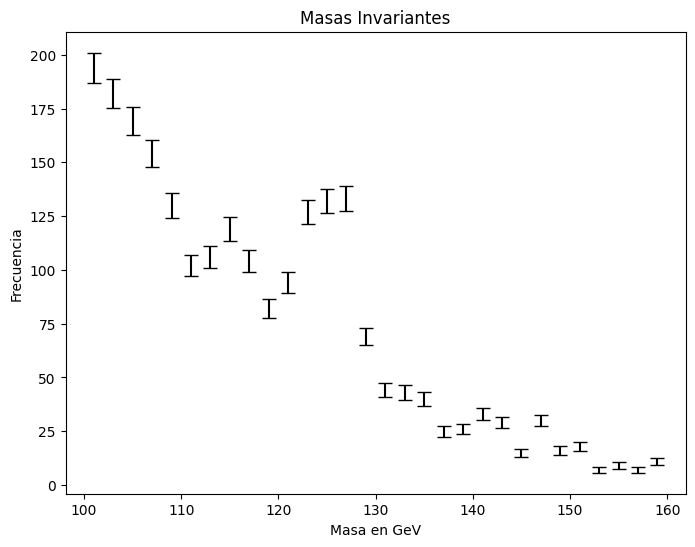

In [142]:
Bines = np.linspace(100, 160, 31)
hist, edges = np.histogram(Masas['masas'], bins=Bines)
bin_centers = 0.5 * (edges[:-1] + edges[1:])
errors = 0.5 * np.sqrt(hist)
plt.figure(figsize=(8, 6))
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', ecolor='k', capsize=5)

plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Masas Invariantes")
plt.show()

In [143]:
def neg_log_likelihood_null(alpha, x):
    likelihood = (1 / alpha) * np.exp(-(x - 100) / alpha)
    return -np.sum(np.log(likelihood))
def neg_log_likelihood_alt(params, x):
    A, mu, sigma, alpha = params
    gauss = A * (1 / (np.sqrt(2 * np.pi) * sigma)) * np.exp(-0.5 * ((x - mu) / sigma)**2)
    exp_bg = (1 - A) * (1 / alpha) * np.exp(-(x - 100) / alpha)
    likelihood = gauss + exp_bg
    return -np.sum(np.log(likelihood))


# Configuración de límites
bounds = [(0, 50)]  # Evitar divisiones por 0

# Optimización
result = minimize(neg_log_likelihood_null, x0=[10], args=(Masas['masas'],), bounds=bounds)
alpha_opt = result.x[0]

print(f"Mejor valor de alpha: {alpha_opt}")

Mejor valor de alpha: 17.61888053628762


In [144]:
# Límites
bounds_alt = [(0, 1), (110, 150), (1, 20), (1, 50)]

# Optimización
initial_guess = [0.5, 125, 10, 10]
result_alt = minimize(neg_log_likelihood_alt, x0=initial_guess, args=(Masas['masas'],), bounds=bounds_alt)
A_opt, mu_opt, sigma_opt, alpha_opt_alt = result_alt.x

print(f"Mejor ajuste: A = {A_opt}, miu = {mu_opt}, sigma = {sigma_opt}, alpha = {alpha_opt_alt}")


Mejor ajuste: A = 0.31053074054746777, miu = 125.52367922557391, sigma = 9.84662064319232, alpha = 14.058627890555398


In [145]:
#se hacen las negaciones
L_null = neg_log_likelihood_null(alpha_opt, Masas['masas'])
L_alt = neg_log_likelihood_alt(result_alt.x, Masas['masas'])

In [146]:
n_sigma = np.sqrt(-2 * (L_alt - L_null))
print(f"Desviaciones estándar (nσ): {n_sigma}")

Desviaciones estándar (nσ): 14.32921033432167


#SI EXISTE EL HIGGS!!


In [147]:
hbar = 6.582e-25  # GeV·s
tau = hbar / sigma_opt
print(f"Tiempo de vida: {tau} s")

Tiempo de vida: 6.684526842770785e-26 s


In [148]:
def LogPrior(p):
  A, mu, sigma, alpha = p
  if 0. < A < 1. and 100. <= mu <= 300. and 0.1 <= sigma <= 20. and 1 <= alpha <= 50:
    return 0.
  else:
    return -np.inf


In [149]:
#eje_x
x_vals = np.linspace(100, 160, 500
                     )
#modelo nulo
null_model = (1 / alpha_opt) * np.exp(-(x_vals - 100) / alpha_opt)


# Calcular el modelo ajustado de la hipótesis alternativa (modelo con resonancia)
alt_model = (
    A_opt * (1 / (np.sqrt(2 * np.pi) * sigma_opt)) * np.exp(-0.5 * ((x_vals - mu_opt) / sigma_opt)**2)
    + (1 - A_opt) * (1 / alpha_opt_alt) * np.exp(-(x_vals - 100) / alpha_opt_alt)
)



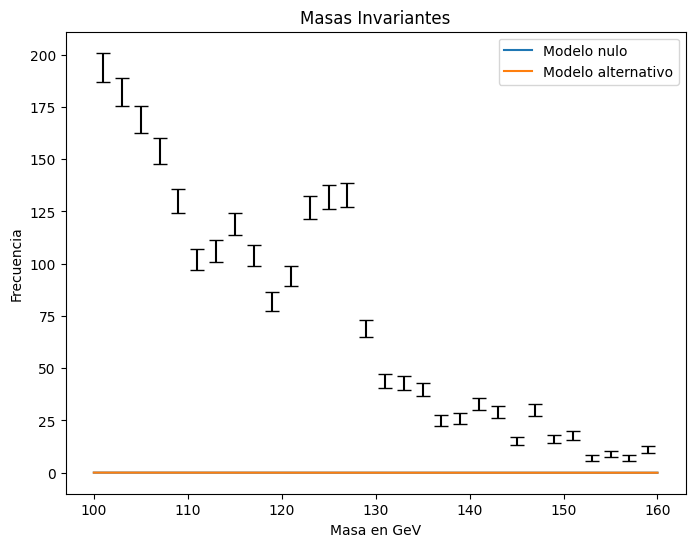

In [150]:
plt.figure(figsize=(8, 6))
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', ecolor='k', capsize=5)
plt.plot(x_vals, alt_model, label='Modelo nulo')
plt.plot(x_vals, null_model, label='Modelo alternativo')
plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Masas Invariantes")
plt.legend()
plt.show()

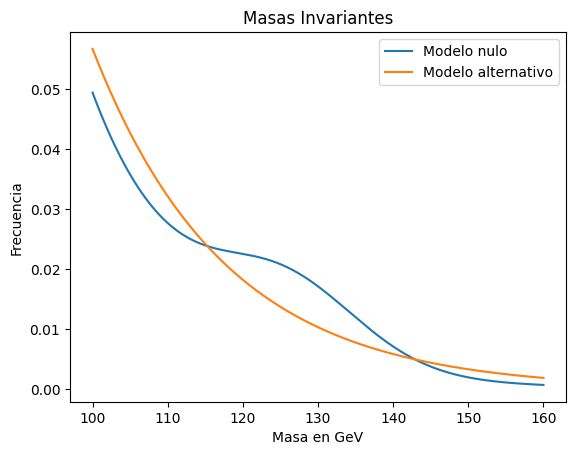

In [151]:
plt.plot(x_vals, alt_model, label='Modelo nulo')
plt.plot(x_vals, null_model, label='Modelo alternativo')
plt.xlabel("Masa en GeV")
plt.ylabel("Frecuencia")
plt.title("Masas Invariantes")
plt.legend()
plt.show()